# Document Similarity Graph Generation

## TODO
 * Explore using simhashing to speed up the similarity lookups, if necessary

In [1]:
from graphviz import Digraph, Graph

import numpy as np

import datetime
import io
import random
import os

In [2]:
random.seed(0xC0FFEE)

In [3]:
%run ../crowd/data.py
%run ../crowd/config.py
%run ../crowd/file_util.py
%run ../crowd/graph.py
%run ../crowd/topic.py

## Load the topic information for improved manual inspection

In [4]:
id_topic_info = load_topic_metadata()

## Load the relevance judgements to improve the visualization

In [5]:
# Turk judgements
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)

# Ground truth
# Note: it seems to be normal that there are duplicates in this dataset.
test_data = read_expert_labels(TEST_LABEL_FILE_SHARED, header=True, sep=',') + \
    read_expert_labels(TEST_LABEL_FILE_TEAMS, header=True, sep=',')

In [6]:
topics = { l.topic_id for l in judgements }

# Some topic ID we want to visualize.
target_topic_id = '20704'
assert target_topic_id in topics
print("Topic we are exploring: [%s]" % id_topic_info[target_topic_id])

Topic we are exploring: [20704:detroit riot]


In [7]:
topic_judgements = [j for j in judgements if j.topic_id == target_topic_id]
doc_ids_in_topic = {j.doc_id for j in topic_judgements}
print("%d turk judgements in topic [%s] of %d documents." % (len(topic_judgements), target_topic_id, len(doc_ids_in_topic)))
print("AVG: %.2f judgements per documents" % (len(topic_judgements) / len(doc_ids_in_topic)))

465 turk judgements in topic [20704] of 90 documents.
AVG: 5.17 judgements per documents


## Load the document data

In [8]:
# Grab every file from the topic, and only look at those whose
# names end in '.txt', i.e. the HTML text with all HTML tags stripped
# away.
file_names = get_topic_file_names(FULLTEXT_FOLDER, target_topic_id)
print("We have %d files." % len(file_names))

We have 141 files.


In [9]:
doc_id_to_doc, corpus = get_topic_files(FULLTEXT_FOLDER, target_topic_id)

## Build and render the document graph

In [10]:
def visualize_graph(graph, base_folder, ground_truth_data, vote_data):
    """ Renders the specified document graph using graphviz."""

    dot = Graph(comment='Similarity graph', engine='neato')
    dot.body.append('size="18,18"')
    dot.body.append('splines=true;')
    dot.body.append('overlap=scalexy;')
    dot.body.append('nodesep=25.0;')
    dot.body.append('label="Topic: %s (%s)"' % (graph.topic.description, graph.topic.query))
    
    relevant_documents, non_relevant_documents = get_relevant(graph.topic_id, ground_truth_data)

    SHORT_NAME_OFFSET = 7
    FILE_URI_PREFIX = 'file://'
    topic_folder = os.path.join(base_folder, str(graph.topic_id))

    # Create the nodes
    for node in graph.nodes:
        name = node.document_id
        short_name = name[name.rfind('-') - SHORT_NAME_OFFSET : name.rfind('.')]
        full_path = FILE_URI_PREFIX + os.path.join(topic_folder, name + ".txt")
        color = "white"
        
        ground_truth_relevant = None
        if name in relevant_documents:
            color = "green"
            ground_truth_relevant = True
        if name in non_relevant_documents:
            color = "red"
            ground_truth_relevant = False
            
        relevant_votes = 0
        irrelevant_votes = 0
        if name in vote_data:
            votes = vote_data[name]
            for vote in votes:
                if vote.is_relevant > 0:
                    relevant_votes += 1
                else:
                    irrelevant_votes += 1
                    
        votes_relevant = None
        if relevant_votes > irrelevant_votes:
            votes_relevant = True
        elif relevant_votes < irrelevant_votes:
            votes_relevant = False
            
        top_color = color
        # What are you talking about? This is perfectly readable!
        bot_color = "lightgray"
        if votes_relevant is True:
            bot_color = "green"
        elif votes_relevant is False:
            bot_color = "red"
          
        border_color = "black"
        if ground_truth_relevant is not None and votes_relevant is not None:
            if ground_truth_relevant != votes_relevant:
                border_color = "yellow"

        # Yes, the extra angular brackets are necessary for graphviz.
        node_label = '''<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4" COLOR="%s">
            <TR><TD BGCOLOR="%s">%s</TD></TR>
            <TR><TD BGCOLOR="%s">(+%d -%d)</TD></TR>
        </TABLE>>''' % (border_color, top_color, short_name, bot_color, relevant_votes, irrelevant_votes)
        dot.node(name, label=node_label, fontsize='7', shape='none', height='0', width='0',
                 tooltip=name, URL=full_path, style='filled', margin='0')

    # Add the edges
    for node in graph.nodes:
        for neighbor in node.neighbors:
            if neighbor.to_document_id > neighbor.from_document_id:
                label = "%.3f" % neighbor.similarity
                dot.edge(
                    neighbor.from_document_id, neighbor.to_document_id,
                    label=label,
                    fontsize='6')
                
    return dot

In [11]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

Built graph with 124 total edges.


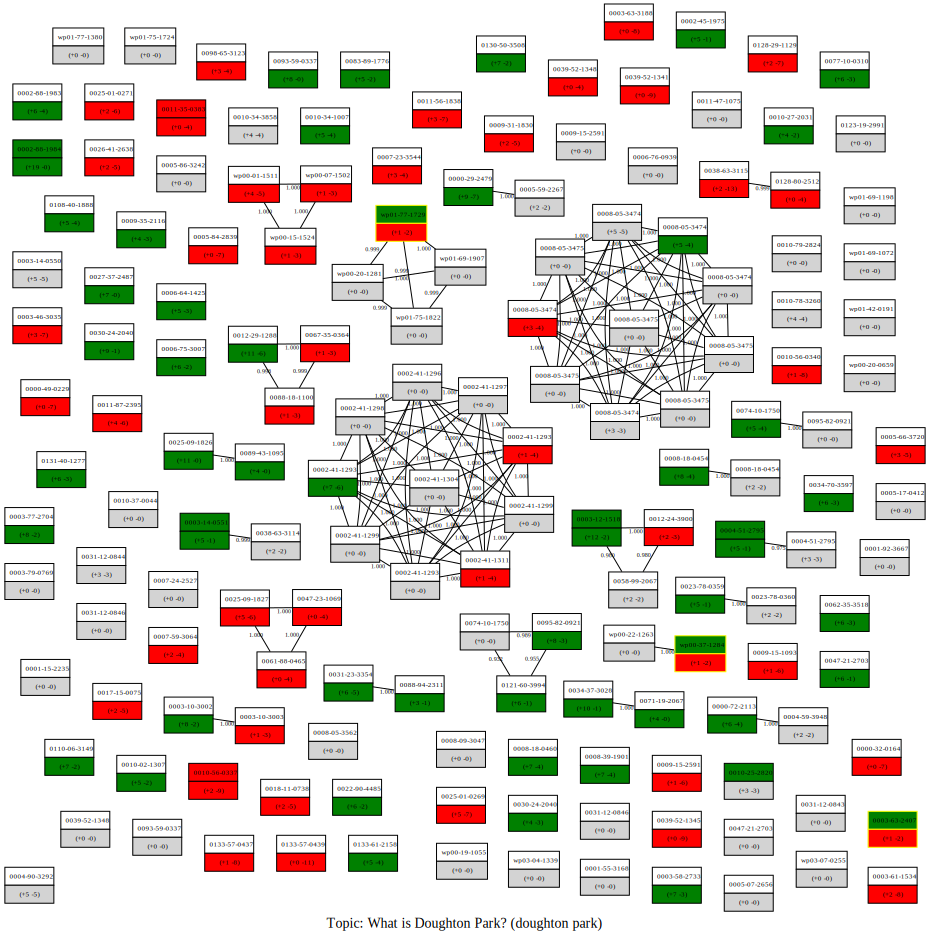

In [12]:
options={"[%s] %s (%d)" % (t.topic_id, t.query, t.document_count) : t.topic_id for t in id_topic_info.values()}

@interact(topic_id=options, sim_threshold=widgets.FloatSlider(min=0.50, max=1.0, step=0.025, continuous_update=False, value=0.90))
def build_and_display(topic_id, sim_threshold):
    # TODO(andrei) Pass this as a parameter.
    topic = id_topic_info[topic_id]
    graph = build_document_graph(topic, FULLTEXT_FOLDER, sim_threshold=sim_threshold)
    # print("Topic description: [%s]" % graph.topic.description)
    graph_dot = visualize_graph(
        graph,
        FULLTEXT_FOLDER,
        test_data,
        get_topic_judgements_by_doc_id(topic_id, judgements))
    return graph_dot